# Imports and Installations
- Kaggle package
- Drive Connection
- Download base

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 15.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
! mkdir ~/.kaggle}
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip '140k-real-and-fake-faces.zip';


In [ ]:
from json import load
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,Compose, Resize, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import pandas as pd
import seaborn as sn

# Auxiliary codes
- Detect GPU
- Load base
- Calculate metrics
- Evaluate model

In [ ]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]

    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
def load_data(path,train_rate,batch_size,test=False):
    NORMALIZE_MEAN = (0.5, 0.5, 0.5)
    NORMALIZE_STD = (0.5, 0.5, 0.5)
    transform = Compose([
              Resize(size=(224, 224)),
              ToTensor(),
              Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ])
    
    #transform = Compose([Resize(size=(384, 384)), ToTensor()])
    dataset_train = ImageFolder(path+"/train", transform=transform)
    dataset_test = ImageFolder(path+"/test", transform=transform)
    dataset_valid =ImageFolder(path+"/valid", transform=transform)

    #train_size = int( len(dataset)* train_rate)
    #test_size = len(dataset) - train_size

    #train_ds,test_ds =  random_split(dataset,[train_size,test_size])

    train_dl = DataLoader(dataset_train,batch_size,shuffle=True)
    test_dl = DataLoader(dataset_test,batch_size)
    valid_dl = DataLoader(dataset_valid,batch_size)
    
    
    return train_dl,test_dl,valid_dl

def accuracy(outputs, labels):
    _,preds = torch.max(outputs,dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))
def validation_epoch_end(outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()

        return {"val_loss":epoch_loss.item(),'val_acc':epoch_acc.item()}
def epoch_end( epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['val_loss'], result['val_acc']))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs =[]

    y_pred = []
    y_true = []
    for batch in val_loader:

        out = model(batch[0])
        y_pred.extend(torch.max(out,dim = 1)[1].data.cpu().numpy())

        labels = batch[1].data.cpu().numpy()
        y_true.extend(labels)

        loss = F.cross_entropy(out,batch[1])
        acc = accuracy(out,batch[1])
        outputs.append({'val_loss': loss.detach(), "val_acc":acc})
        #break
    return validation_epoch_end(outputs), y_true,y_pred

In [ ]:
train,test,valid = load_data('/content/real_vs_fake/real-vs-fake',0.8,64)

## Evaluating the Deit_16Patch_224 model

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:

device = get_default_device()
model_dict_path = '/content/drive/MyDrive/deit_base_patch16_224.pt'
model= torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.head = nn.Linear(768,2)


model.load_state_dict(torch.load(model_dict_path))
model.to(device)


deit_16_model = model
deit_16_model.blocks[-1].attn.qkv.register_forward_hook(get_activation('qkv'))
img = Image.open("/content/real_vs_fake/real-vs-fake/test/fake/06TAEXDQGR.jpg")
transform = Compose([Resize(size=(224, 224)), ToTensor()])
x = transform(img)
x.size()
x = x.cuda()
logits = deit_16_model(x.unsqueeze(0))
att_mat = activation['qkv']
print(activation['qkv'].size())
input_expanded = activation['qkv'][0]
print(input_expanded.shape)
qkv = input_expanded.reshape(197, 3, 12, 768//12)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


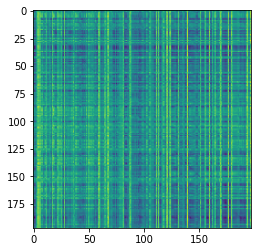

In [ ]:
'''
Baseado no seguinte notebook :
https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb#scrollTo=elFemlXZXQ19
'''

# Attention Matrix
import matplotlib.pyplot as plt

attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

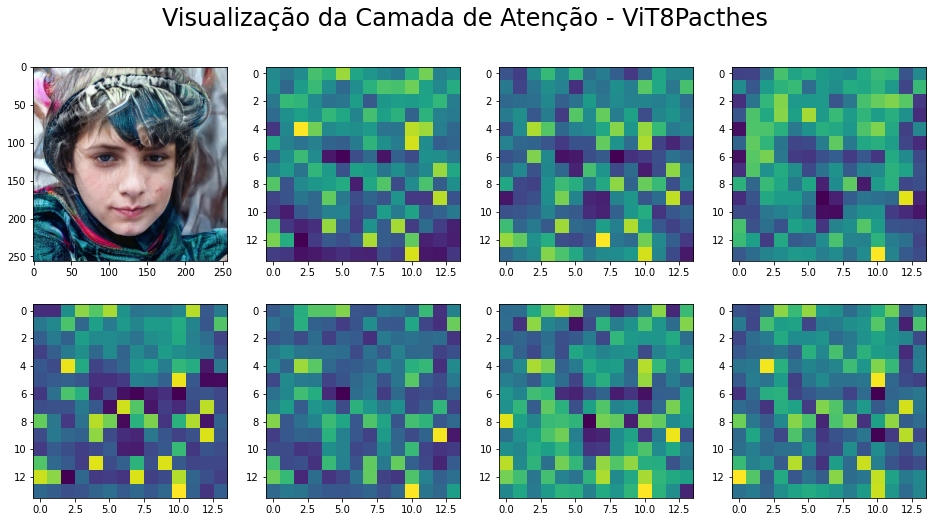

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualização da Camada de Atenção - ViT8Pacthes", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(5,12):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, -1, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i-3)
    ax.imshow(attn_heatmap)

In [ ]:
device = get_default_device()
test = DeviceDataLoader(test,device)
#valid = DeviceDataLoader(valid,device)

metrics,y_true,y_pred = evaluate(deit_16_model,test)
epoch_end(1,metrics)

Epoch [1], val_loss: 0.1721, val_acc: 0.9320


### Confusion Matrix

[[9340  660]
 [ 701 9299]]


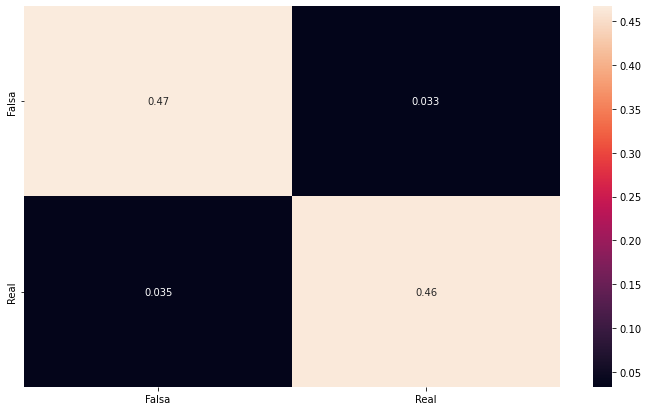

In [ ]:
classes = ('Falsa','Real')
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

plt.show()

In [ ]:
metrics = precision_recall_fscore_support(y_true,y_pred)
print("Precisão:")
print("0:", metrics[0][0],"1:",metrics[0][1])
print("Sensibilidade:")
print("0:", metrics[1][0],"1:",metrics[1][1])
print("F-Score")
print("0:", metrics[2][0],"1:",metrics[2][1])
print("Support")
print("0:", metrics[3][0],"1:",metrics[3][1])

Precisão:
0: 0.9301862364306344 1: 0.9337282859724872
Sensibilidade:
0: 0.934 1: 0.9299
F-Score
0: 0.932089217104935 1: 0.9318102109324113
Support
0: 10000 1: 10000


In [ ]:
torch.cuda.empty_cache()